# Model Building Notebook

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

%matplotlib inline

import pymc3 as pm
import arviz as az

az.rcParams["plot.max_subplots"] = 50

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
data = pd.read_csv('prepared_data.csv')
data.head()

,FLAG_GENDER_MALE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,OCCUPATION_TYPE,STATUS_PREV,College_Education,Currently_Married,Marriage_Status,Paying_Housing,White_Collar,AGE_YR,YRS_WORKED,target_paid
0,1,1,1,0,112500.0,Security staff,X,0,1,Married,1,0,58.0,3.0,1
1,1,1,1,0,112500.0,Security staff,0,0,1,Married,1,0,58.0,3.0,1
2,1,1,1,0,112500.0,Security staff,0,0,1,Married,1,0,58.0,3.0,1
3,1,1,1,0,112500.0,Security staff,X,0,1,Married,1,0,58.0,3.0,1
4,1,1,1,0,112500.0,Security staff,0,0,1,Married,1,0,58.0,3.0,1


In [3]:
# De-Duplicating on First Run for Speed
print(sum(data.groupby('STATUS_PREV').size()))
print(data.groupby('STATUS_PREV').size())
print(data.groupby('target_paid').size())

data = data.drop_duplicates()

print(sum(data.groupby('STATUS_PREV').size()))
print(data.groupby('STATUS_PREV').size())
print(data.groupby('target_paid').size())

298667
STATUS_PREV
0    195095
1      6220
2       530
3       178
4       148
5      1028
X     95468
dtype: int64
target_paid
0      6138
1    292529
dtype: int64
14801
STATUS_PREV
0    7857
1    1777
2     293
3     122
4      91
5     126
X    4535
dtype: int64
target_paid
0     2329
1    12472
dtype: int64


In [4]:
data.loc[data['STATUS_PREV'] == 'X', 'STATUS_PREV'] = '6'
data['STATUS_PREV'] = data['STATUS_PREV'].astype('int64')

In [5]:
# Hierarchical Variable
num_status = len(data['STATUS_PREV'].unique())
status = data['STATUS_PREV'].values

# Numeric Predictors
children = data['CNT_CHILDREN'].values
income = data['AMT_INCOME_TOTAL'].values
age = data['AGE_YR'].values
yrs_worked = data['YRS_WORKED'].values

# Categorical Predictors
male = data['FLAG_GENDER_MALE'].values
car = data['FLAG_OWN_CAR'].values
realty = data['FLAG_OWN_REALTY'].values
college = data['College_Education'].values
married = data['Currently_Married'].values
pay_housing = data['Paying_Housing'].values
white_collar = data['White_Collar'].values

# Interaction Terms
### TBD ###

# Response Variable
target_paid = data['target_paid'].values

## Model 1 - No Offsets

In [9]:
with pm.Model() as log_hier_model_1:
    
    ## HyperParameters for Predictors ##
    
    # Intercept
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=5)
    sigma_b0 = pm.HalfCauchy('sigma_b0', beta=5)
    
    # Children
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=5)
    sigma_b1 = pm.HalfCauchy('sigma_b1', beta=5)
    
    # Income
    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=5)
    sigma_b2 = pm.HalfCauchy('sigma_b2', beta=5)
    
    # Age
    mu_b3 = pm.Normal('mu_b3', mu=0, sigma=5)
    sigma_b3 = pm.HalfCauchy('sigma_b3', beta=5)
    
    # Years Worked
    mu_b4 = pm.Normal('mu_b4', mu=0, sigma=5)
    sigma_b4 = pm.HalfCauchy('sigma_b4', beta=5)
    
    # Male
    mu_b5 = pm.Normal('mu_b5', mu=0, sigma=5)
    sigma_b5 = pm.HalfCauchy('sigma_b5', beta=5)
    
    # Car
    mu_b6 = pm.Normal('mu_b6', mu=0, sigma=5)
    sigma_b6 = pm.HalfCauchy('sigma_b6', beta=5)
    
    # Realty
    mu_b7 = pm.Normal('mu_b7', mu=0, sigma=5)
    sigma_b7 = pm.HalfCauchy('sigma_b7', beta=5)
    
    # College
    mu_b8 = pm.Normal('mu_b8', mu=0, sigma=5)
    sigma_b8 = pm.HalfCauchy('sigma_b8', beta=5)
    
    # Married
    mu_b9 = pm.Normal('mu_b9', mu=0, sigma=5)
    sigma_b9 = pm.HalfCauchy('sigma_b9', beta=5)
    
    # Pay Housing
    mu_b10 = pm.Normal('mu_b10', mu=0, sigma=5)
    sigma_b10 = pm.HalfCauchy('sigma_b10', beta=5)
    
    # White Collar
    mu_b11 = pm.Normal('mu_b11', mu=0, sigma=5)
    sigma_b11 = pm.HalfCauchy('sigma_b11', beta=5)
    
    
    ## Hierarchical Predictors ##
    
    # Intercept
    b0 = pm.Normal('b0', mu=mu_b0, sigma=sigma_b0, shape=num_status)
    
    
    ## Predictors ##
    
    # Normal Predictors - Numeric
    b1 = pm.Normal('b', mu=mu_b1, sigma=sigma_b1)
    b2 = pm.Normal('b2', mu=mu_b2, sigma=sigma_b2)
    b3 = pm.Normal('b3', mu=mu_b3, sigma=sigma_b3)
    b4 = pm.Normal('b4', mu=mu_b4, sigma=sigma_b4)
    
    # Normal Predictors - Categorical
    b5 = pm.Normal('b5', mu=mu_b5, sigma=sigma_b5)
    b6 = pm.Normal('b6', mu=mu_b6, sigma=sigma_b6)
    b7 = pm.Normal('b7', mu=mu_b7, sigma=sigma_b7)
    b8 = pm.Normal('b8', mu=mu_b8, sigma=sigma_b8)
    b9 = pm.Normal('b9', mu=mu_b9, sigma=sigma_b9)
    b10 = pm.Normal('b10', mu=mu_b10, sigma=sigma_b10)
    b11 = pm.Normal('b11', mu=mu_b11, sigma=sigma_b11)
    
    
    ## Model ##
    
    # Regression Equation
    linear_function = b0[status] + b1*children + b2*income +  b3*age + b4*yrs_worked + b5*male + /
                      b6*car + b7*realty + b8*college + b9*married + b10*pay_housing + b11*white_collar
        
    # # Trying Out Subsets of Variables
    # linear_function = b0 + b1*children +  b3*age + b4*yrs_worked + b5*male 
    
    # Convert to Logistic
    p = pm.invlogit(linear_function)
    y = pm.Bernoulli('y', p, observed=target_paid)

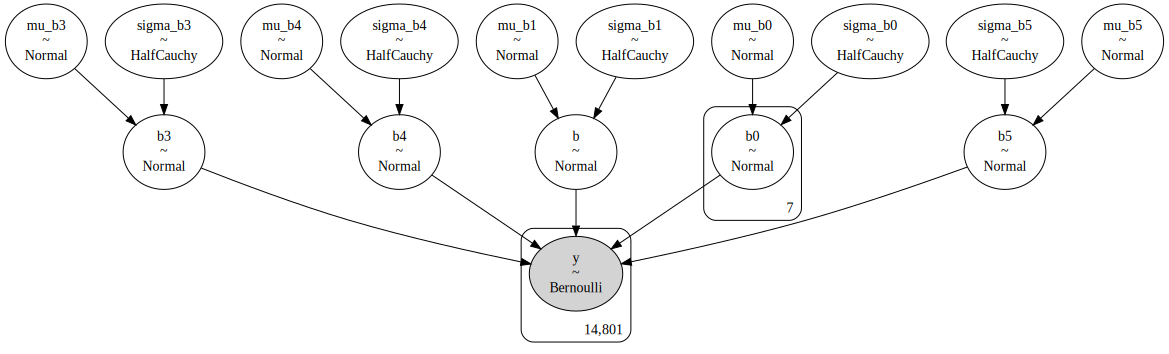

In [10]:
pm.model_to_graphviz(log_hier_model_1)

In [ ]:
with log_hier_model_1:
    
    step = None
    # step = pm.NUTS(target_accept = 0.99)
    
    # cores = None
    cores = 1
    
    # chains = None
    chains = 2
    
    samples = 3000
    
    log_hier_trace_1 = pm.sample(samples, tune=samples, chains=chains, step = step, cores=cores)

C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b5, b4, b3, b, b0, sigma_b5, mu_b5, sigma_b4, mu_b4, sigma_b3, mu_b3, sigma_b1, mu_b1, sigma_b0, mu_b0]


In [ ]:
with log_hier_model_1:
    az.plot_trace(log_hier_trace_1)

In [ ]:
with log_hier_model_1:
    az.plot_forest(log_hier_trace_1, rope=(0, 0))

## Model 2 - GLM

In [ ]:
with pm.Model() as log_model_2:
    
    pm.glm.GLM.from_formula(
        formula = 'target_paid ~ CNT_CHILDREN+ AGE_YR + YRS_WORKED', 
        data = data, 
        family = pm.glm.families.Binomial())
    
    log_trace_2 = pm.sample(1000)
    
# Note - AMT_INCOME_TOTAL Causing Error When Added Here

In [ ]:
pm.model_to_graphviz(log_model_2)

In [ ]:
with log_model_2:
    az.plot_trace(log_trace_2)

In [ ]:
with log_model_2:
    az.plot_forest(log_trace_2, rope=(0, 0))